Osnabrück University - Machine Learning (Summer Term 2018) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 10

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, June 17, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Classification [8 Points]

In the lecture (ML-09 Slides 7ff) several types of classifiers have been introduced. In this assignment you will explore differences and similarities between them.

### a) LDA

How does the LDA classifier work? What restrictions have to be fullfilled by the data for this method to work and why?

LDA makes predictions by estimating the probability that a new input datum belongs to each class. The class that gets the highest probability is the output class and a prediction is made. It stores statistical properties of the data (mean and covariance) for each class, which are then used to estimate the probability of a new datum belonging to a class using Bayes' Theorem.

**Restrictions:**
- Classes have identical a priori probability
- Classes exhibit a Gaussian distribution
- Covariances are assumed to be identical for all classes

### b) Nearest Neighbor

How does the nearest neighbor classifier work? When would you use it and how is it trained?

The nearest neighbour classifier memorizes all training examples and returns the class of best matching/nearest neighbour of a previously unseen input datum. The problem of this classifier is its memory consumption, since it needs to store all training samples. Additionally, finding the best matching sample can also take a while (is not necessarily trivial).

### c) Support Vector Machines

Name some differences between a SVM and a MLP. When would you use which?

An SVM learns decision boundaries while a MLP learns weights that minimize the squared error.

| SVM | MLP |
| --- | --- |
| linear separatrix (mostly) | non-linear separatrix |
| binary classification | multi-class classification |
| can handle outliers | cannot handle outliers |

MLPs are better with a very large dataset, and especially if the features are very sparse, and can probably handle noise better (training time doesn’t depend on noise), while SVMs take a really long time to train. They can also be very slow if the decision boundary is complicated/the data is very noisy.

### d) Random forests

Explain in your own words the concept of a *random forest*. What is meant by *bagging of trees* and *bagging of features* and what are the respective benefits? How do radom forests allow for *parallelization* in *training* and *classification*? 

A random forest is a classification technique where several independent decision trees are generated and the output class is decided by *asking* each tree and choosing the class with the most votes. The processes of training and classification can be parallelized because all trees are independet, so they can be generated on their own and can compute their decision on their own.

**Bagging Tress:**  
This is the process of repeatedly selecting a random subset of the training set and fitting trees to these samples.

**Bagging Features:**  
Pretty much the same, just with selecting a random samples from the set of all features.

These methods of bagging results in a more controlled variance and less overfitting.

## Assignment 2: Reinforcement Learning [12 Points]

In this assignment you will have a look at the Q-Learning algorithm described in the lecture (ML-10 Slide 18). For this we generate a field with random rewards. A learning agent is then exploring the field and learns the optimal path to navigate through it. The code below is again filled with some ``TODO``s that should be filled by you in order to implement the Q-Learning algorithm. 

Below the code there are some questions! You also find a free-code field for a complete own implementation. You may use your own test mazes.

In [12]:
import numpy as np
import numpy.random as rand

def generate_field(x, y, num_rewards, max_reward):
    """
    Generate a random game field with rewards.
    
    Args:
        x (int):            x dimension of the field
        y (int):            y dimension of the field 
        num_rewards (int):  the number of rewards that should be randomly placed
        max_reward (int):   the maximum reward that can be placed 
        
    Returns:
        ndarray: A field with randomly initialized rewards, the rest of the 
        entries is zero
    """
    field = np.zeros((y,x), dtype=np.uint8)
    
    for i in range(num_rewards):
        field[rand.randint(y), rand.randint(x)] = rand.choice(max_reward)
    
    return field

In [14]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
#from sklearn.preprocessing import normalize

class QLearning:
    """
    This class contains all the necessary methods to navigate through
    a maze or game with the help of a little bit of Q-Learning.
    """

    def __init__(self, field, actions, gamma=0.9, color='inferno'):
        """
        Initializes the QLearning Algorithm with the necessary parameters.
        All q values are stored in self.q - this is an array that has
        ACTIONS x map_x x map_y dimensions to store a value for each action
        in each field. The starting position self.pos is randomly initialized.
        
        Args:
            field (ndarray):  the map
            actions (list):   the available actions
            gamma (float):    the gamma in the lecture slides
        
        Returns:
            QLearning: An instance that can be used for Q-Learning on the field
        """
        # q stores the q_values for each action in each space of the field.
        self.field = field
        self.actions = actions
        self.gamma = gamma
        
        # Remember the map extend for further navigation.
        self.map_y = self.field.shape[0]
        self.map_x = self.field.shape[1]
        
        # Create q value matrix.
        self.q = np.zeros((len(self.actions), self.map_x, self.map_y))

        # Start on a random position in the field.
        self.pos = [np.random.randint(self.map_x),np.random.randint(self.map_y)]
        
        # Colors for nicer plotting
        self.color = color


    def get_coordinates(self, position, action):
        """
        Returns the coordinates that follow a certain action, depending
        on the current position of the learner. If the border is reached
        the agent just stops there.
        
        Args:
            position (pair):  the current position
            action (string):  the action that should be performed (one of: 'up', 'down', ...)
            
        Returns:
            pair of int: the updated coordinates
        """
        # return the right new coordinates depending on the position
        if self.is_valid_move(position, action):
            movex, movey = self.calc_diff(action) 
            return (position[0]+movex, position[1]+movey)
        else:
            return position

    def update(self):
        """
        Implementation of the update step. Closely follows the Algorithm described on
        ML-10 Sl.18. Note that you have attributes available as specified in the
        __init__ method of this class, in addition to that is the FIELD variable that
        stores the real field the agent is iterating about, as well as ACTIONS which
        stores the available actions.
        """
        # Select a random action that should be performed next.
        # Be careful to handle the case where you hit the wall!
        action = np.random.choice(self.actions)
        while not self.is_valid_move(self.pos, action):
            action = np.random.choice(self.actions)
        new_pos = self.get_coordinates(self.pos, action)
            
        # Receive the reward for the new position from the field.
        reward = self.field[new_pos[0], new_pos[1]]
        
        # Update the q-value for the performed action.
        act_index = self.action_index(action)
        self.q[act_index, self.pos[0], self.pos[1]] = reward + self.gamma * self.estimate_q(new_pos, action)

        # Update the position of the player to the new field.
        self.pos = new_pos

    def action_index(self, action):
        for i,move in enumerate(self.actions):
            if move == action:
                return i
        raise RuntimeError('action not contained in actions')
        
    def calc_diff(self, action):
        """
        Calculate the difference that needs to be applied when
        performing the specified action.
        
        Args:
            action (string)         : action to be performed
        """
        movex = 1
        movey = 0
        if action == 'down':
            movey = -1
            movex = 0
        elif action == 'up':
            movey = 1
            movex = 0
        elif action == 'left':
            movex = -1
        
        return (movex, movey)
        
    def is_valid_move(self, position, action):
        """
        Checks whether the specified action applied to the given
        position is a valid move.
        
        Args:
            position (pair of ints) : tuple of ints, indication position
            action (string)         : action to be performed
            
        Returns:
            bool                    : whether action is valid
        """
        movex, movey = self.calc_diff(action)
                    
        return position[0]+movex < self.map_x and position[1]+movey < self.map_y \
                and position[0]+movex >= 0 and position[1]+movey >= 0
        
    def estimate_q(self, position, action):
        """
        Computes q-value for the state induced by position.
        
        Args:
            position (pair of ints) : tuple of ints, indication position
            action (string)         : action that led to this state
            
        Returns:
            value (float)           : maximum of all other moves 
        """
        vals = []
        for move in self.actions:
            if move != action:
                if self.is_valid_move(position, move):
                    act_index = self.action_index(move)
                    vals.append(self.q[act_index, position[0], position[1]])
                else:
                    vals.append(0)
        return max(vals)
                

    def plot(self):
        """
        Plots the current state.
        """
        fig_player = plt.figure('QLearning State')

        for i, direc in enumerate(ACTIONS):
            plt.subplot(3,3,2*i+2)
            plt.axis('off')
            plt.title(direc)
            #normalized = normalize(self.q[i,:,:], axis=0).ravel()
            plt.imshow(self.q[i,:,:], interpolation = 'None', cmap=self.color)

        fig_player.canvas.draw()

<IPython.core.display.Javascript object>


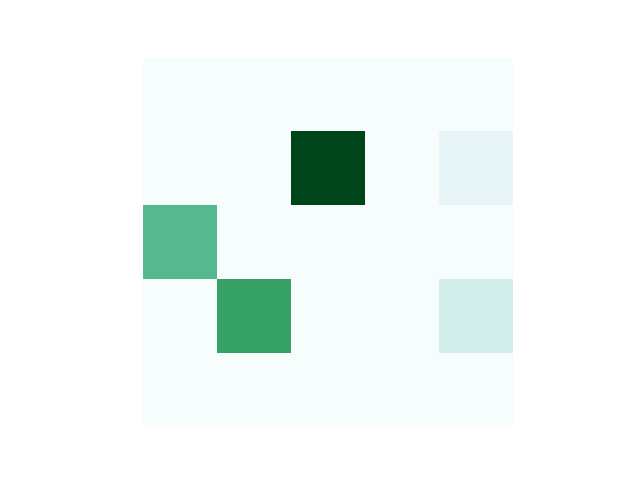

<IPython.core.display.Javascript object>


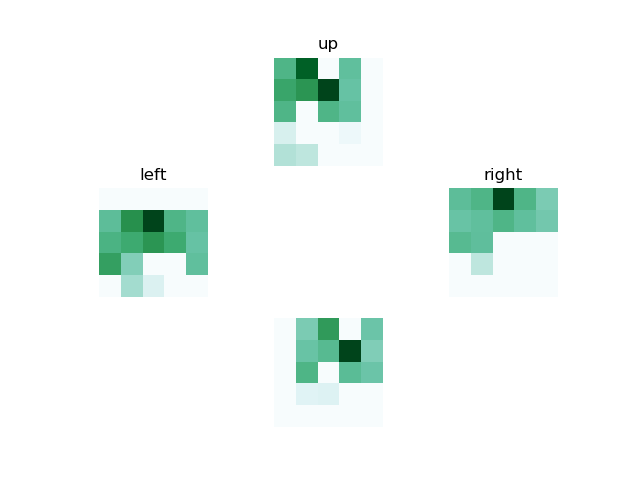

D:\Anaconda\envs\ml\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


KeyboardInterrupt: 

In [18]:
%matplotlib notebook

import matplotlib.pyplot as plt

# Determine the size of the field, change this parameters as you like
m_x = 5
m_y = 5

steps = 300
color = 'BuGn'

ACTIONS = ['up','left','right','down']  # Those are the availabe actions for the QLearning.
FIELD = generate_field(m_x, m_y, 5, 10) # The field that is used for learning.

# Plotting the generated field
figure = plt.figure('Field')
plt.axis('off')
plt.imshow(FIELD, interpolation='none', cmap=color)
figure.canvas.draw()

# Generate a QLearning instance with the right parameters.
player = QLearning(FIELD, ACTIONS, color=color)

# Now we perform steps many learning iterations on the field with
# the generated QLearning instance.
for i in range(steps):     
    player.update()
    player.plot()

Explain in your own words, how the algorithm works. What is depicted on the resulting plots. How can an action policy be derived from these data?

**Algorithm:**  

Q-learning is a type of reinforcement learning, where an agent transitions between possible states dependeing on the action he took. Every state provides a reward, which is a weighted sum of the expected values of the rewards of all future steps starting from the current state. Every reward from an action is weighted by a discount factor, to let earlier rewards be more valuable than later ones (learning).

**Plots:**  

For each action, the expected reward for performing that action when in the given state (e.g. at that position on the field) is depicted, where blue values mean that the reward is low while green values indicate that the reward is high.

**Strategies:**
1. Simply take the path that maximizes the expected reward (=q).
2. Choose an action according to a probability weighted by the q-value.

You are also free to write your complete own implementation of the QLearning algorithm (instead of completing the code above). Use the following cell for your implementation.

In [ ]:
# YOUR CODE HERE